# Data Mining Challenge 2020

## Team
* Diego Cumming 10709685

# This is the Prediction Notebook. To get the prediction as a csv, please run the cells in order until the last one. It doesn't take too long.

In [86]:
''' PACKAGES'''
import pandas as pd             

import numpy as np

import seaborn as sns
sns.set(style="dark", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

from math import ceil

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime as dt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from catboost import CatBoostRegressor
from sklearn import neighbors

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist, pdist

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [87]:
''' DATA PRE-PROCESSING'''
df=pd.read_csv('train.csv')
df.rename(columns={'Unnamed: 0':'week', 'size (GM)':'size', 'POS_exposed w-1':'nos_w-1', 'volume_on_promo w-1':'vop_w-1',
                   'sales w-1':'sales_w-1'},inplace=True)
df['sku']=df['sku'].apply(str)
df['week'] = df['week'].map(lambda x: x.lstrip('WE '))
def dateFormat(date_str):
    return dt.strptime(date_str, '%d %B %Y')
df['week']=df['week'].apply(dateFormat)

df2=pd.read_csv('x_test.csv')
df2.rename(columns={'Unnamed: 0':'week', 'size (GM)':'size', 'POS_exposed w-1':'nos_w-1', 'volume_on_promo w-1':'vop_w-1',
                   'sales w-1':'sales_w-1'},inplace=True)
df2['sku']=df2['sku'].apply(str)
df2['week'] = df2['week'].map(lambda x: x.lstrip('WE '))
def dateFormat(date_str):
    return dt.strptime(date_str, '%d %B %Y')
df2['week']=df2['week'].apply(dateFormat)

In [88]:
skus=df.loc[df['scope']==1]['sku'].drop_duplicates().reset_index(drop=True)
week=df['week'].drop_duplicates().reset_index(drop=True).to_frame()

skus2=df2['sku'].drop_duplicates().reset_index(drop=True)
week2=df2['week'].drop_duplicates().reset_index(drop=True).to_frame()

In [89]:
### Time series of All SKU
target=week.copy()
price=week.copy()
nos_w1=week.copy()
vop_w1=week.copy()
sales_w1=week.copy()
for index, row in skus.items():
    target[row]=df[df['sku']==row].reset_index()['target']
    price[row]=df[df['sku']==row].reset_index()['price']
    nos_w1[row]=df[df['sku']==row].reset_index()['nos_w-1']
    vop_w1[row]=df[df['sku']==row].reset_index()['vop_w-1']
    sales_w1[row]=df[df['sku']==row].reset_index()['sales_w-1']
target.set_index('week',inplace=True)
price.set_index('week',inplace=True)
nos_w1.set_index('week',inplace=True)
vop_w1.set_index('week',inplace=True)
sales_w1.set_index('week',inplace=True)
nos_w1.dropna(inplace=True)
vop_w1.dropna(inplace=True)
sales_w1.dropna(inplace=True)

price2=week2.copy()
nos_w12=week2.copy()
vop_w12=week2.copy()
sales_w12=week2.copy()
for index, row in skus.items():
    price2[row]=df2[df2['sku']==row].reset_index()['price']
    nos_w12[row]=df2[df2['sku']==row].reset_index()['nos_w-1']
    vop_w12[row]=df2[df2['sku']==row].reset_index()['vop_w-1']
    sales_w12[row]=df2[df2['sku']==row].reset_index()['sales_w-1']
price2.set_index('week',inplace=True)
nos_w12.set_index('week',inplace=True)
vop_w12.set_index('week',inplace=True)
sales_w12.set_index('week',inplace=True)
nos_w12.dropna(inplace=True)
vop_w12.dropna(inplace=True)
sales_w12.dropna(inplace=True)


target=pd.concat([target,week2.set_index('week')])
price=pd.concat([price,price2])
nos_w1=pd.concat([nos_w1,nos_w12])
vop_w1=pd.concat([vop_w1,vop_w12])
sales_w1=pd.concat([sales_w1,sales_w12])
week=pd.concat([week,week2]).reset_index()

In [90]:
weather_data=np.array([5.7,6.5,8.6,11.7,15.7,19.5,22.4,22.4,19.5,15,10.3,6.9]) #https://www.weatherbase.com/
familiar_consumption=pd.read_csv('fc.csv',header=None) #Congiuntura.Stat
familiar_consumption.columns=['quarter','consumption']
familiar_consumption['quarter'] = familiar_consumption['quarter'].map(lambda x: x.lstrip('T'))
familiar_consumption.set_index('quarter',inplace=True)
w=week.copy()
fc=week.copy()
for i,r in week.iterrows():
    w.loc[i,'weather']=weather_data[w.loc[i,'week'].month-1]
    fc.loc[i,'consumption']=familiar_consumption.loc[str(ceil(fc.loc[i,'week'].month/3))+
                                                     '-'+str(fc.loc[i,'week'].year),'consumption']
w.set_index('week',drop=True,inplace=True)
fc.set_index('week',drop=True,inplace=True)

In [91]:
sku=df['sku'].copy().to_frame()
sku_features=['pack', 'size', 'brand','scope']
for features in sku_features:
    sku[features]=df[features].copy()

sku.drop_duplicates(inplace=True)
sku.set_index('sku',inplace=True)
sku.drop(index=sku[(sku['scope']!=1)].index,inplace=True)

In [93]:
lags=2

variables=['price[i].shift(lag).dropna()', 'nos_w1[i].shift(lag).dropna()',
           'vop_w1[i].shift(lag).dropna()','sales_w1[i].shift(lag).dropna()']
names=['price', 'nos_w1','vop_w1','sales_w1']
for i,r in sku.iterrows():
    exec('sku_'+str(i)+'=pd.DataFrame(index=week.loc[lags+1:,"week"])')
    exec('sku_'+str(i)+'["w"]=w.iloc[lags+1]["weather"]')
    exec('sku_'+str(i)+'["fc"]=fc.iloc[lags+1]["consumption"]')
    exec('sku_'+str(i)+'["t"]=target.loc[week.loc[lags+1,"week"]:,i]')
for lag in range(0,lags+1):
    for variable,name in zip(variables,names):
        for i,row in sku.iterrows():
            exec('sku_'+str(i)+'[name+"_"+str(lag)]='+variable)
        

In [95]:
relevant_features={'1027': ['price_0'],
 '1035': ['price_0'],
 '144': ['price_0', 'nos_w1_0', 'vop_w1_2'],
 '1051': ['price_0', 'vop_w1_2'],
 '546': ['price_0'],
 '1058': ['price_0'],
 '549': ['price_0'],
 '1065': ['price_0', 'nos_w1_0', 'sales_w1_0'],
 '554': ['price_0', 'nos_w1_0'],
 '686': ['price_0', 'nos_w1_0', 'vop_w1_2'],
 '688': ['price_0'],
 '1206': ['price_0', 'vop_w1_0', 'sales_w1_0']}

In [96]:
def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

for sk in relevant_features:
    exec('skuf_'+sk+'=pd.DataFrame(index=week.loc[lags+1:,"week"])')
    for feature in relevant_features[sk]:
        exec('skuf_'+sk+'[feature+"_"+sk]=sku_'+sk+'[feature]')
    for osk in removekey(relevant_features,sk):
        for feature in relevant_features[osk]:
            exec('skuf_'+sk+'[feature+"_"+osk]=sku_'+osk+'[feature]')
    exec('skuf_'+sk+'["t"]=target.loc[week.loc[lags+1,"week"]:,sk]')
    exec('skuf_'+sk+'=skuf_'+sk+'.reindex(skuf_1027.columns, axis=1)')
        

In [43]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [44]:
xgb_optimal_params=[np.array([0.10651188, 0.4       , 8.        ]),
 np.array([0.1787556, 0.35     , 6.       ]),
 np.array([0.0225327, 0.45      , 5.       ]),
 np.array([0.0225327, 0.4      , 8.       ]),
 np.array([0.0225327, 0.4      , 5.       ]),
 np.array([0.03781593, 0.35      , 8.        ]),
 np.array([0.06346531, 0.25      , 6.        ]),
 np.array([0.10651188, 0.25      , 5.        ]),
 np.array([0.10651188, 0.25      , 8.        ]),
 np.array([0.3, 0.45, 8. ]),
 np.array([0.01342615, 0.3       , 6.        ]),
 np.array([0.008, 0.25 , 6.   ])]

<Figure size 432x288 with 0 Axes>

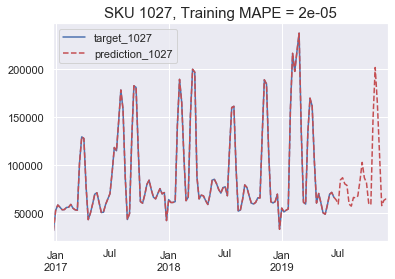

<Figure size 432x288 with 0 Axes>

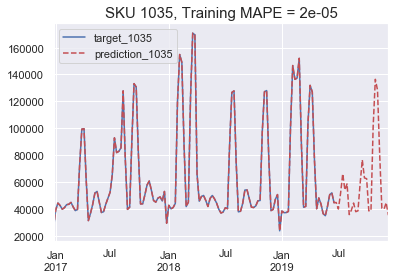

<Figure size 432x288 with 0 Axes>

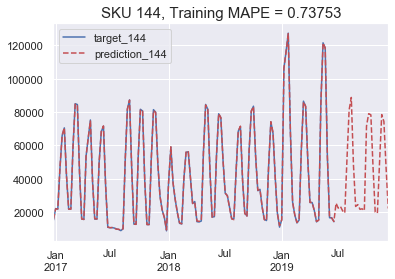

<Figure size 432x288 with 0 Axes>

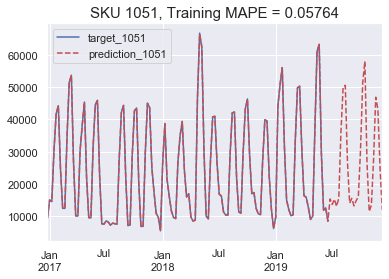

<Figure size 432x288 with 0 Axes>

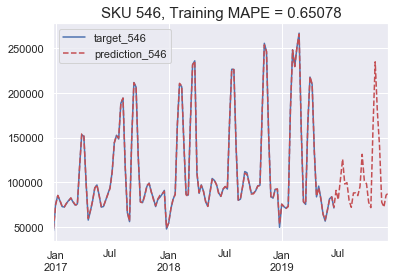

<Figure size 432x288 with 0 Axes>

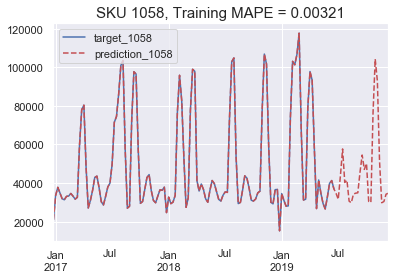

<Figure size 432x288 with 0 Axes>

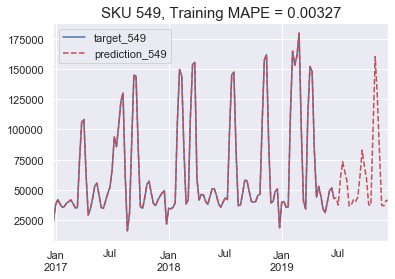

<Figure size 432x288 with 0 Axes>

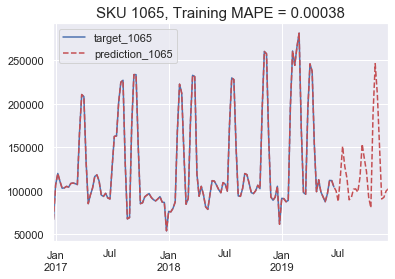

<Figure size 432x288 with 0 Axes>

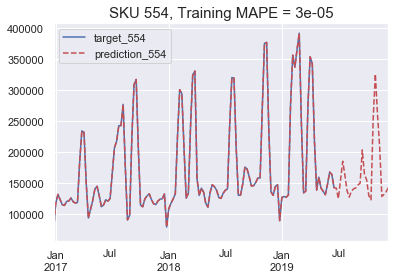

<Figure size 432x288 with 0 Axes>

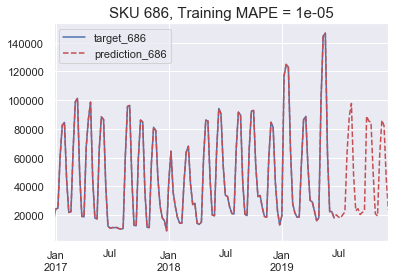

<Figure size 432x288 with 0 Axes>

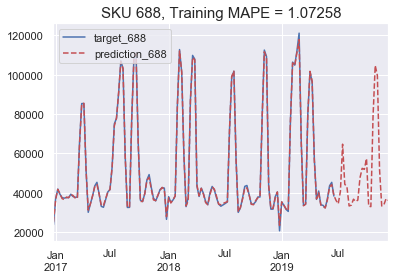

<Figure size 432x288 with 0 Axes>

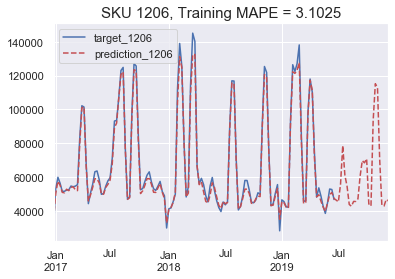

In [157]:
initial_epoch=51
final_epoch=129
cont=0
mapes=[]
y_prediction=pd.DataFrame(index=week.loc[lags+1:,"week"])
for i,r in sku.iterrows():
    data=eval('skuf_'+i)
    y_prediction['target_'+i]=data["t"]
    y_prediction['prediction_'+i]=pd.Series(np.ones((data.shape[0]))*np.nan,index=data.index)
    
    Xtr = data[data.drop(columns=['t']).columns].iloc[:final_epoch+1]
    ytr = data["t"].iloc[:final_epoch+1]

    XG_regr = xgb.XGBRegressor(colsample_bytree = xgb_optimal_params[cont][1],
                               learning_rate = float(xgb_optimal_params[cont][0]),
        max_depth = int(xgb_optimal_params[cont][2]), n_estimators = 500)

    XG_regr.fit(np.array(Xtr),np.array(ytr))
    
    yptr = pd.Series(XG_regr.predict(np.array(Xtr)),index=ytr.index,dtype=float)
    
    y_prediction.iloc[:final_epoch+1,
                      y_prediction.columns.get_loc('prediction_'+i)]=yptr
    
    mape=mean_absolute_percentage_error(ytr, yptr)
    mapes.append(mape)
    
    for epoch in range(final_epoch+1,data.shape[0]):
        Xp=data[data.drop(columns=['t']).columns].iloc[epoch]
        Xp=np.array(Xp).reshape(1, -1)
        yp = XG_regr.predict(Xp)
        y_prediction.iloc[epoch,
                      y_prediction.columns.get_loc('prediction_'+i)]=yp[0]
        
    cont+=1
    plt.figure()
    ax=y_prediction[['target_'+i,'prediction_'+i]].plot(style=['b','r--'])
    ax.set_xlabel("")
    plt.title('SKU '+i+', Training MAPE = '+str(round(mape,5)),fontsize=15)
    plt.legend(loc=2)
    plt.grid()
    plt.savefig(i+'.png', bbox_inches='tight')
    plt.show()

In [168]:
cont=0
predictions=[]
for i,r in sku.iterrows():
    for epoch in range(final_epoch+1,y_prediction.shape[0]):
        predictions.append(y_prediction.iloc[epoch]['prediction_'+i])
predictions=pd.Series(np.array(predictions))
predictions.to_csv('predictions.csv',index=False,header=False)